<a href="https://colab.research.google.com/github/yeesem/Soft-Computing/blob/main/Assignment_3_Evolutionary_Computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [3]:
pip install ucimlrepo

In [4]:
pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=1d5ff8a5a12621ae8ec699c02e7553d462addb90480df606385054a88151c3de
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [5]:
pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.1 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import statistics
import random
from itertools import product
from functools import reduce

from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [7]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
taiwanese_bankruptcy_prediction = fetch_ucirepo(id=572)

# data (as pandas dataframes)
X = taiwanese_bankruptcy_prediction.data.features
y = taiwanese_bankruptcy_prediction.data.targets

# Dataset Cleaning and Preprocessing

In [8]:
features = X.copy()

# Check for null values
print("Columns with null value")
print("-----------------------------------")
print("{:15} {:15}".format("Column","Num of null values"))
for col in features.columns:
  number_of_null_values = features[col].isna().sum()
  if number_of_null_values > 0:
    print(col)
    print("{:-15} {:-15}".format(col,number_of_null_values))

Columns with null value
-----------------------------------
Column          Num of null values


In [9]:
# Check for col with object dtype
features.select_dtypes('object').columns

Index([], dtype='object')

In [10]:
features.select_dtypes('int').columns

Index([' Liability-Assets Flag', ' Net Income Flag'], dtype='object')

In [11]:
print("Unique value of Liability-Assets Flag : ", features[' Liability-Assets Flag'].unique())
print("Unique value of Net Income Flag : ", features[' Net Income Flag'].unique())

Unique value of Liability-Assets Flag :  [0 1]
Unique value of Net Income Flag :  [1]


In [12]:
print("Number of Liability-Assets Flag == 0 : ",len(features[features[' Liability-Assets Flag'] == 0]))
print("Number of Liability-Assets Flag == 1 : ",len(features[features[' Liability-Assets Flag'] == 1]))

Number of Liability-Assets Flag == 0 :  6811
Number of Liability-Assets Flag == 1 :  8


In [13]:
features.drop(columns = features.select_dtypes('int').columns,inplace = True)

In [14]:
# Imbalance Dataset
print("Number of Bankrupt == 0 : " , len(y[y['Bankrupt?'] == 0]))
print("Number of Bankrupt == 1 : " , len(y[y['Bankrupt?'] == 1]))

Number of Bankrupt == 0 :  6599
Number of Bankrupt == 1 :  220


In [15]:
df = pd.concat([features,y],axis = 1)
df.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794,1
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,0.016474,1
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,0.023982,1
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,0.035490,1


In [16]:
# Upsampling
features_majority = df[df['Bankrupt?'] == 0]
features_minority = df[df['Bankrupt?'] == 1]

features_minority_upsample = resample(
    features_minority,
    replace = True,
    n_samples = len(features_majority),
    random_state = 123
)

df = pd.concat([features_majority,features_minority_upsample])

print("Number of rows of features dataframe : ", len(df))
print("Number of Bankrupt == 0 : " , len(df[df['Bankrupt?'] == 0]))
print("Number of Bankrupt == 1 : " , len(df [df['Bankrupt?'] == 1]))

df.head()

Number of rows of features dataframe :  13198
Number of Bankrupt == 0 :  6599
Number of Bankrupt == 1 :  6599


,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?
6,0.390923,0.445704,0.436158,0.619950,0.619950,0.998993,0.797012,0.808960,0.302814,0.781180,...,0.736619,0.018372,0.623655,0.619949,0.829980,0.292504,0.026622,0.564200,0.015663,0
7,0.508361,0.570922,0.559077,0.601738,0.601717,0.999009,0.797449,0.809362,0.303545,0.781621,...,0.815350,0.010005,0.623843,0.601739,0.841459,0.278607,0.027031,0.566089,0.034889,0
8,0.488519,0.545137,0.543284,0.603612,0.603612,0.998961,0.797414,0.809338,0.303584,0.781598,...,0.803647,0.000824,0.623977,0.603613,0.840487,0.276423,0.026891,0.565592,0.065826,0
9,0.495686,0.550916,0.542963,0.599209,0.599209,0.999001,0.797404,0.809320,0.303483,0.781574,...,0.804195,0.005798,0.623865,0.599205,0.840688,0.279388,0.027243,0.566668,0.030801,0
10,0.482475,0.567543,0.538198,0.614026,0.614026,0.998978,0.797535,0.809460,0.303759,0.781629,...,0.814111,0.076972,0.623687,0.614021,0.841337,0.278356,0.026971,0.565892,0.036572,0


In [17]:
# Split Dataset into train and test sets
X = df.drop(['Bankrupt?'],axis = 1)
y = df['Bankrupt?']
X_train,X_test,y_train,y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

print("Training features : ", len(X_train))
print("Testing features  : ", len(X_test))
print("Training labels   : ", len(y_train))
print("Testing labels    : ", len(y_test))

Training features :  10558
Testing features  :  2640
Training labels   :  10558
Testing labels    :  2640


# Features Selection - GA algorithms <br>
Types of fitness function
*   Logistics Regression
*   Random Forest Regression <br>

Selection methods

*   Tournament Selection
*   Rank Selection
*   Roulette-wheel Selection

Mutation methods


*   Bit Flip Mutation
*   Gaussian Mutation

Stopping Criteria

*   When fitness value > 0.998
*   When best fitness value does not improve for 15 consecutive generations

Changes of mutation and crossover rate every generation loop [TRUE / FALSE]


*   crossover_rate *= 1.05
*   mutation_rate *= 0.99











In [18]:
def fitness_function_random_forest(individual,data,target):
  # Filter the features based on the individual's chromosome
  selected_features = [feature for feature,bit in zip(data.columns,individual) if bit == 1]
  if not selected_features:
    return (0.0,)
  X = data[selected_features]
  model = RandomForestClassifier(random_state = 42)
  model.fit(X,target)
  score =model.score(X_test[selected_features],y_test)
  return (score,)

def fitness_function_logistics_regression(individual,data,target):
  selected_features = [feature for feature,bit in zip(data.columns,individual) if bit == 1]
  if not selected_features:
    return (0.0,)
  X = data[selected_features]
  model = LogisticRegression()
  model.fit(X,target)
  pred = model.predict(X_test[selected_features])
  acc = accuracy_score(y_test,pred)
  return (acc,)

In [19]:
# Define a random state seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

def feature_selection_genetic_algo(data,features,target,population_size,num_generations,fitness_type,num_desired_features = 5,selection_type = 'tournament',mutation_type = 'bitflip',crossover_rate = 0.7,mutation_rate = 0.01,changes_of_rates = True):
  collection_of_fitnesses = []
  best_fitness_in_generation = 0
  best_ind_in_generation = None

  # Create the Fitness and Individual classes
  creator.create("FitnessMax",base.Fitness,weights = (1.0,))
  creator.create("Individual",list,fitness = creator.FitnessMax)

  # Initialize the toolbox
  toolbox = base.Toolbox()

  # Attribute generator: Define a function to randomly generate a feature selector (0 or 1)
  toolbox.register('attr_bool',random.randint,0,1)

  # Structure initializers: Define a function to create individuals and the population
  # toolbox.register('individual',init_individual,creator.Individual,size = len(features),num_features = 10)
  toolbox.register('individual',tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(features))
  toolbox.register('population',tools.initRepeat,list,toolbox.individual)

  # Register the evaluation function
  if fitness_type == 'randomforest':
    toolbox.register("evaluate",fitness_function_random_forest,data = data,target = target)
  elif fitness_type == 'logistic':
    toolbox.register("evaluate",fitness_function_logistics_regression,data = data,target = target)

  toolbox.register('mate',tools.cxTwoPoint)

  if mutation_type == 'bitflip':
    toolbox.register('mutate',tools.mutFlipBit,indpb = 0.05)
  elif mutation_type == 'gaussian':
    toolbox.register('mutate',tools.mutGaussian,mu = 0,sigma = 1,indpb = 0.5)

  if selection_type == 'tournament':
    toolbox.register('select',tools.selTournament,tournsize  = 3)
  elif selection_type == 'roulette':
    toolbox.register('select',tools.selRoulette)
  elif selection_type == 'rank':
    toolbox.register('select',tools.selBest)

  # Initialize population
  population = toolbox.population(n = population_size)

  fitnesses = list(map(toolbox.evaluate,population))

  for ind,fit in zip(population,fitnesses):
    ind.fitness.values = fit

  # Variable keeping track of the number of generations
  gen = 0

  while gen < num_generations:
    gen+=1

    # Select the next generation individuals
    offspring = toolbox.select(population,len(population))

    # Clone the selected individuals
    offspring = list(map(toolbox.clone,offspring))

    # Apply crossover and mutation on the offspring
    for child1,child2 in zip(offspring[::2],offspring[1::2]):
      if random.random() < crossover_rate:
        toolbox.mate(child1,child2)
        del child1.fitness.values
        del child2.fitness.values

    for mutant in offspring:
      if random.random() < mutation_rate:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]

    fitnesses = map(toolbox.evaluate,invalid_ind)

    for ind,fit in zip(invalid_ind,fitnesses):
      ind.fitness.values = fit

    # Replace the population with the offspring
    population[:] = offspring

    # Stopping criteria
    best_ind_in_population = tools.selBest(population,1)[0]
    best_fitness_in_population = best_ind_in_population.fitness.values[0]

    selected_features = [feature for feature,bit in zip(data.columns,best_ind_in_population) if bit == 1]

    print("Generation        : ",gen)
    print("Selected Features : ",selected_features)
    print("Best Fitness      : ",best_fitness_in_population)
    print()

    if changes_of_rates:
        #  Modify crossover rate and mutation -rate every generation loop
        crossover_rate *= 1.05
        mutation_rate *= 0.99

    collection_of_fitnesses.append(best_fitness_in_population)

    if best_fitness_in_population > best_fitness_in_generation:
      best_fitness_in_generation = best_fitness_in_population
      best_ind_in_generation = best_ind_in_population
      count_num_gen = 0
    else:
      count_num_gen += 1

    if best_fitness_in_population >= 0.998:
      break

    if count_num_gen == 15:
      break

  # Select the top N features from the best individual
  selected_features = [features[i] for i in range(len(best_ind_in_generation)) if best_ind_in_generation[i] == 1]

  if len(selected_features) > num_desired_features:
    X = data[selected_features]
    model = RandomForestClassifier()
    model.fit(X,target)
    feature_importances = model.feature_importances_
    important_features = sorted(zip(selected_features,feature_importances),key = lambda x : x[1],reverse = True)
    best_features = [feature for feature,importance in important_features[:num_desired_features]]
  else:
    best_features = selected_features

  return collection_of_fitnesses,best_features,best_fitness_in_generation

In [20]:
# Plot the convergence
def plot_fitness_history(fitnesses,title):
  plt.plot(fitnesses)
  plt.xlabel("Generation")
  plt.ylabel("Best Fitness Value")
  plt.title(title)
  plt.grid()
  plt.show()

In [21]:
# Parameters
data = X_train
features = X_train.columns
target = y_train
population_size = 15
num_generations = 50

# Fitness Function with Logistic Regression

**Fixed MUT,SEL Rates**

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' ROA(C) before interest and depreciation before interest', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Continuous Net Profit Growth Rate', ' Total Asset Growth Rate', ' Total Asset Return Growth Rate Ratio', ' Cash Reinvestment %', ' Current Ratio', ' Quick Ratio', ' Debt ratio %', ' Net worth/Assets', ' Long-term fund suitability ratio (A)', ' Contingent liabilities/Net worth', ' Operating profit/Paid-in capital', ' Inventory and accounts receivable/Net valu

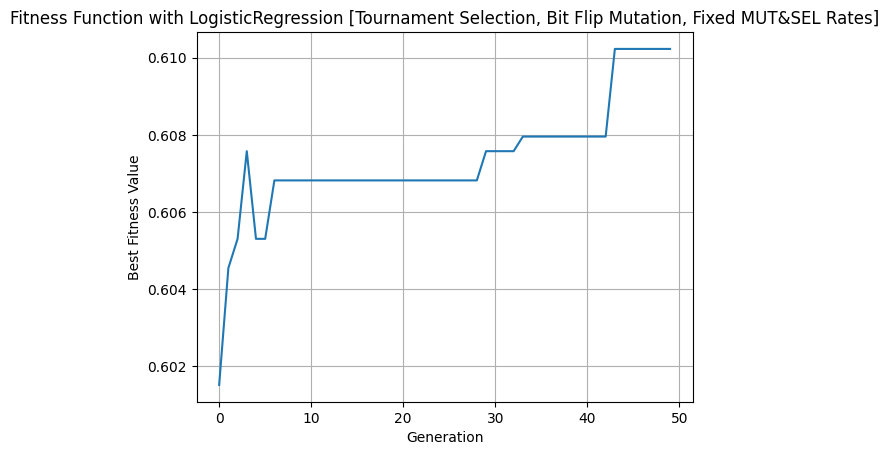

In [ ]:
fitness_type = 'logistic'
num_desired_features = 5
selection_type = 'tournament'
mutation_type = 'bitflip'
crossover_rate = 0.6
mutation_rate = 0.08
changes_of_rates = False

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with LogisticRegression [Tournament Selection, Bit Flip Mutation, Fixed MUT&SEL Rates]")

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' Realized Sales Gross Margin', ' Pre-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Cash flow rate', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Total Asset Return Growth Rate Ratio', ' Current Ratio', ' Quick Ratio', ' Interest Expense Ratio', ' Debt ratio %', ' Long-term fund suitability ratio (A)', ' Contingent liabilities/Net worth', ' Operating profit/Paid-in capital', ' Average Collection Days', ' Revenue per person', ' Operating profit per person', ' Allocation rate per person', ' Working Capital to Total Assets', ' Current Assets/Total Assets', ' Cash/Total Assets', ' Cash/Current Liability', ' Current Liabilities/Liability', ' Working Capital/Equity', ' Current Liabilities/Equity', 

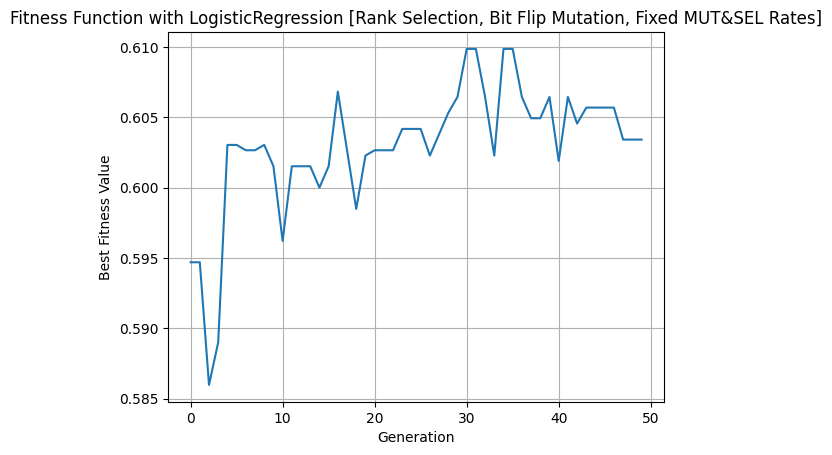

In [ ]:
fitness_type = 'logistic'
num_desired_features = 5
selection_type = 'rank'
mutation_type = 'bitflip'
crossover_rate = 0.7
mutation_rate = 0.01
changes_of_rates = False

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with LogisticRegression [Rank Selection, Bit Flip Mutation, Fixed MUT&SEL Rates]")

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' ROA(A) before interest and % after tax', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Continuous interest rate (after tax)', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Revenue Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Operating Profit Growth Rate', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Quick Ratio', ' Interest Expense Ratio', ' Total debt/Total net worth', ' Long-term fund suitability ratio (A)', ' Borrowing dependency', ' Contingent liabilities/Net worth', ' Operating profit/Paid-in capital', ' Net profit before tax/Paid-in capital', ' Inventory and accounts receivable/Net value', ' Total Asset Turnover', ' Accounts Rec

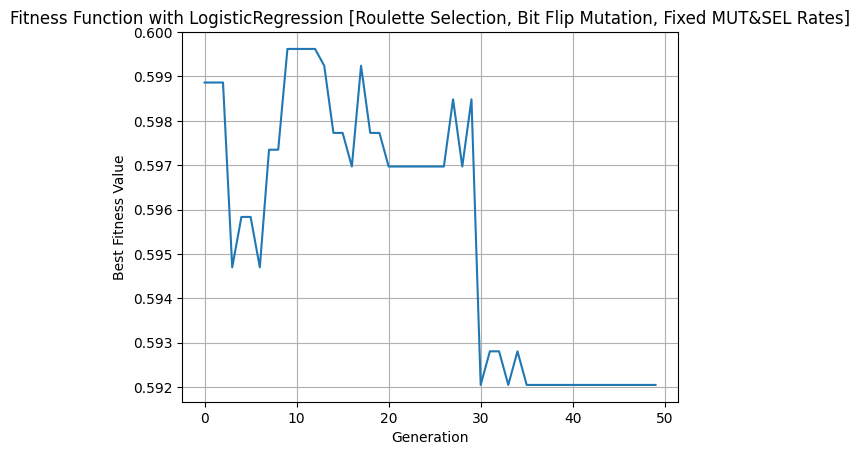

In [ ]:
fitness_type = 'logistic'
num_desired_features = 5
selection_type = 'roulette'
mutation_type = 'bitflip'
crossover_rate = 0.7
mutation_rate = 0.01
changes_of_rates = False

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with LogisticRegression [Roulette Selection, Bit Flip Mutation, Fixed MUT&SEL Rates]")

**Dynamic MUT&SEL Rates**

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' Realized Sales Gross Margin', ' Pre-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Continuous Net Profit Growth Rate', ' Total Asset Return Growth Rate Ratio', ' Cash Reinvestment %', ' Interest Expense Ratio', ' Debt ratio %', ' Net worth/Assets', ' Operating profit/Paid-in capital', ' Net profit before tax/Paid-in capital', ' Average Collection Days', ' Fixed Assets Turnover Frequency', ' Revenue per pers

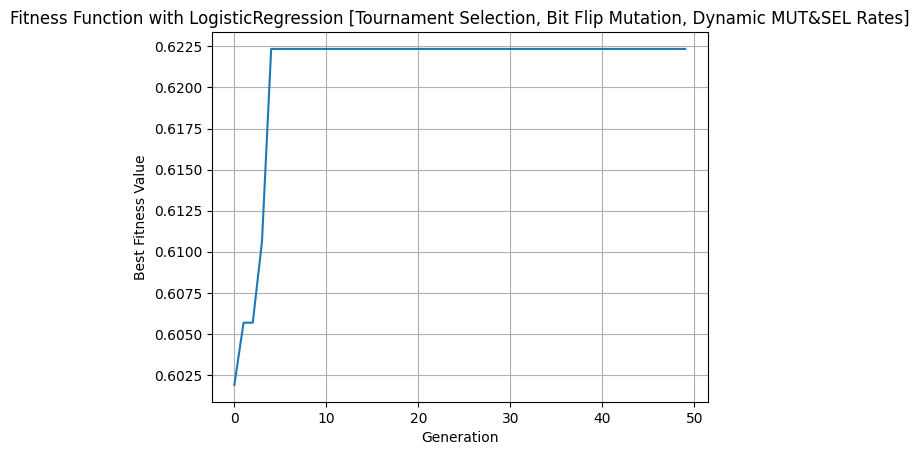

In [ ]:
fitness_type = 'logistic'
num_desired_features = 5
selection_type = 'tournament'
mutation_type = 'bitflip'
crossover_rate = 0.7
mutation_rate = 0.01
changes_of_rates = True

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with LogisticRegression [Tournament Selection, Bit Flip Mutation, Dynamic MUT&SEL Rates]")

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Total Asset Return Growth Rate Ratio', ' Cash Reinvestment %', ' Total debt/Total net worth', ' Net worth

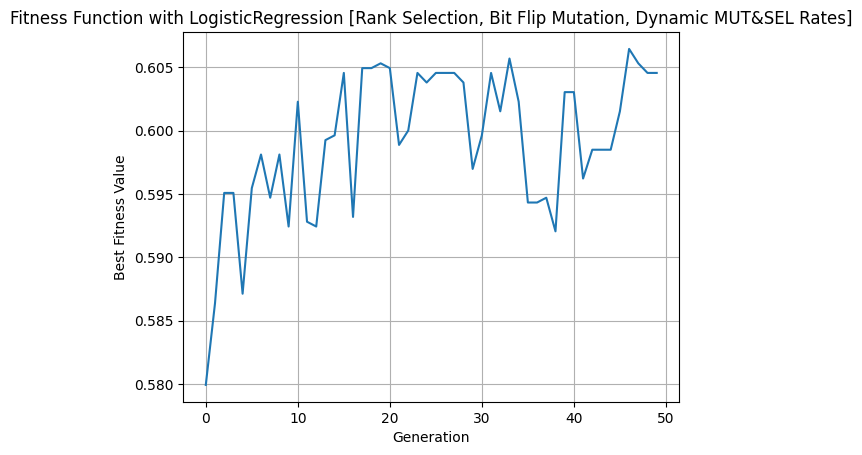

In [ ]:
fitness_type = 'logistic'
num_desired_features = 5
selection_type = 'rank'
mutation_type = 'bitflip'
crossover_rate = 0.7
mutation_rate = 0.01
changes_of_rates = True

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with LogisticRegression [Rank Selection, Bit Flip Mutation, Dynamic MUT&SEL Rates]")

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' Operating Gross Margin', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Tax rate (A)', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Operating Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Continuous Net Profit Growth Rate', ' Total Asset Growth Rate', ' Total Asset Return Growth Rate Ratio', ' Cash Reinvestment %', ' Quick Ratio', ' Interest Expense Ratio', ' Debt ratio %', ' Borrowing dependency', ' Operating profit/Paid-in capital', ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover Frequency', ' Operating profit per person', ' Allocation rate per person', ' Quick Assets/Total Assets', ' Current Assets/Total Assets', ' Quick Assets/Current Liability', ' Cash/Current Liability', ' Working Capital/Equity', ' Current Liabilities/Equity', ' Lon

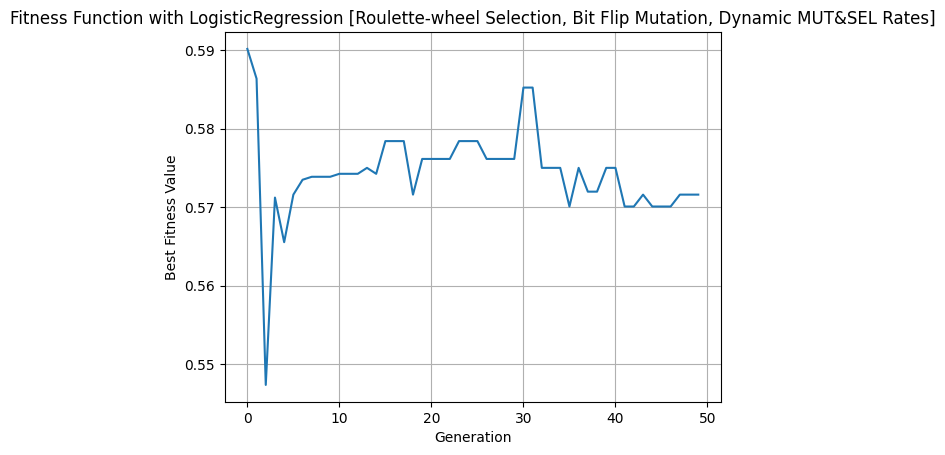

In [ ]:
fitness_type = 'logistic'
num_desired_features = 5
selection_type = 'roulette'
mutation_type = 'bitflip'
crossover_rate = 0.7
mutation_rate = 0.01
changes_of_rates = True

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with LogisticRegression [Roulette-wheel Selection, Bit Flip Mutation, Dynamic MUT&SEL Rates]")

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Net Value Per Share (B)', ' Net Value Per Share (C)', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Total Asset Growth Rate', ' Cash Reinvestment %', ' Current Ratio', ' Quick Ratio', ' Long-term fund suitability ratio (A)', ' Borrowing dependency', ' Inventory and accounts receivable/Net value', ' Total Asset Turnover', ' Accounts Receivable Turnover', ' Average Collection Days', ' Fixed Assets Turnover Frequency', ' Operating profit per person', '

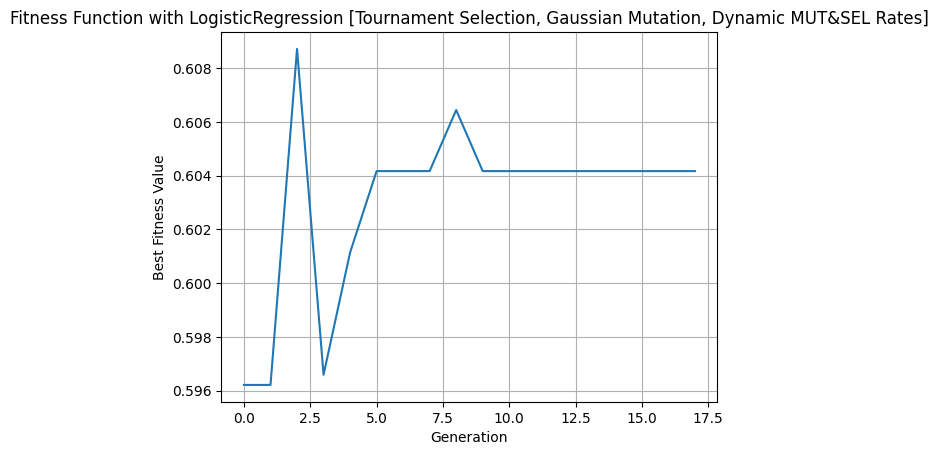

In [ ]:
fitness_type = 'logistic'
num_desired_features = 5
selection_type = 'tournament'
mutation_type = 'gaussian'
crossover_rate = 0.7
mutation_rate = 0.01
changes_of_rates = True

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with LogisticRegression [Tournament Selection, Gaussian Mutation, Dynamic MUT&SEL Rates]")

# Fitness Function with Random Forest Classifier

**Fixed MUT&SEL Rates**

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' After-tax net Interest Rate', ' Continuous interest rate (after tax)', ' Research and development expense rate', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Operating Profit Growth Rate', ' Continuous Net Profit Growth Rate', ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Cash Reinvestment %', ' Quick Ratio', ' Interest Expense Ratio', ' Total debt/Total net worth', ' Net worth/Assets', ' Contingent liabilities/Net worth', ' Operating profit/Paid-in capital', ' Total Asset Turnover', ' Revenue per person', ' Operating profit per person', ' Allocation rate per person', ' Cash/Total Assets', ' Cash/Current Liability', ' Operating Funds to Liability', ' Inventory/Working Capital', ' Inventory/Current Liability', ' Working Capital/Equity',

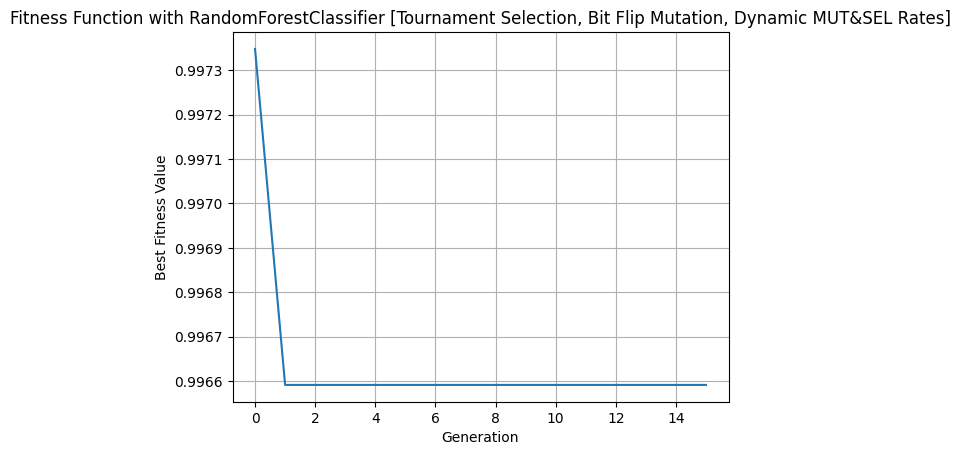

In [ ]:
fitness_type = 'randomforest'
num_desired_features = 5
selection_type = 'tournament'
mutation_type = 'bitflip'
crossover_rate = 0.7
mutation_rate = 0.01
changes_of_rates = False

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with RandomForestClassifier [Tournament Selection, Bit Flip Mutation, Dynamic MUT&SEL Rates]")

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' Operating Expense Rate', ' Research and development expense rate', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Operating Profit Growth Rate', ' Continuous Net Profit Growth Rate', ' Net Value Growth Rate', ' Cash Reinvestment %', ' Interest Expense Ratio', ' Debt ratio %', ' Operating profit/Paid-in capital', ' Net profit before tax/Paid-in capital', ' Average Collection Days', ' Fixed Assets Turnover Frequency', ' Revenue per person', ' Operating profit per person', ' Allocation rate per person', ' Working Capital to Total Assets', ' Quick Asset

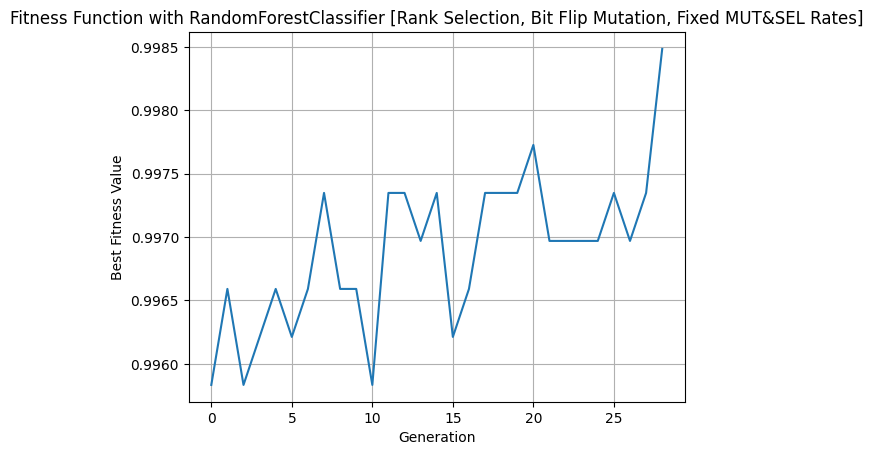

In [ ]:
fitness_type = 'randomforest'
num_desired_features = 5
selection_type = 'rank'
mutation_type = 'bitflip'
crossover_rate = 0.7
mutation_rate = 0.01
changes_of_rates = False

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with RandomForestClassifier [Rank Selection, Bit Flip Mutation, Fixed MUT&SEL Rates]")

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' ROA(C) before interest and depreciation before interest', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Net Value Growth Rate', ' Total Asset Return Growth Rate Ratio', ' Net worth/Assets', ' Long-term fund suitability ratio (A)', ' Accounts Receivable Turnover', ' Average Collection Days', ' Revenue per person', ' Operating profit per person', ' Allocat

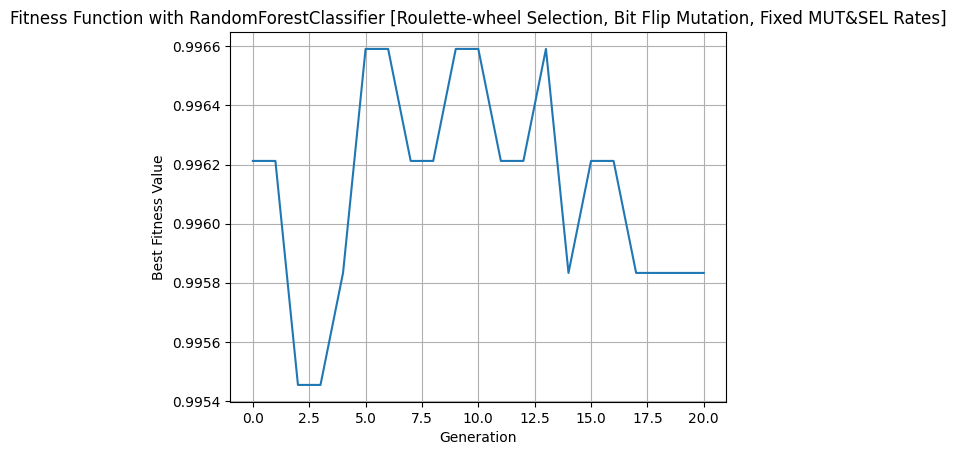

In [ ]:
fitness_type = 'randomforest'
num_desired_features = 5
selection_type = 'roulette'
mutation_type = 'bitflip'
crossover_rate = 0.7
mutation_rate = 0.01
changes_of_rates = False

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with RandomForestClassifier [Roulette-wheel Selection, Bit Flip Mutation, Fixed MUT&SEL Rates]")

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' ROA(C) before interest and depreciation before interest', ' ROA(B) before interest and depreciation after tax', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Tax rate (A)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Operating Profit Growth Rate', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Total Asset Return Growth Rate Ratio', ' Cash Reinvestment %', ' Current Ratio', ' Quick Ratio', ' Total debt/Total net worth', ' Long-term fund suitability ratio (A)', ' Borrowing dependency', ' Inventory and accounts receivable/Net value', ' Total Asset Turnover', ' Accounts Receivable Turnover', ' Average Collection Days', ' Inventory Turnover Rate (times)', ' Fixed

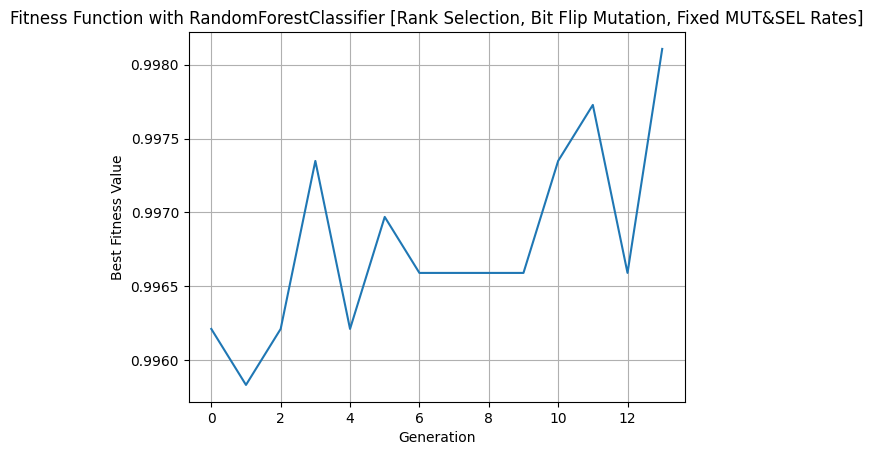

In [ ]:
fitness_type = 'randomforest'
num_desired_features = 5
selection_type = 'rank'
mutation_type = 'gaussian'
crossover_rate = 0.7
mutation_rate = 0.01
changes_of_rates = False

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with RandomForestClassifier [Rank Selection, Bit Flip Mutation, Fixed MUT&SEL Rates]")

**Dynamic MUT&SEL Rates**

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Research and development expense rate', ' Cash flow rate', ' Tax rate (A)', ' Persistent EPS in the Last Four Seasons', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Operating Profit Growth Rate', ' Continuous Net Profit Growth Rate', ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Quick Ratio', ' Debt ratio %', ' Net profit before tax/Paid-in capital', ' Inventory Turnover Rate (times)', ' Net Worth Turnover Rate (times)', ' Operating profit per person', ' Working Capital to Total Assets', ' Cash/Total Assets', ' Cash/Current Liability', ' Current Liability to Assets', ' Inventory/Working Capital', ' Inventory/Current Liability', ' Current Liabilities/Liability', ' Long-term Liability to C

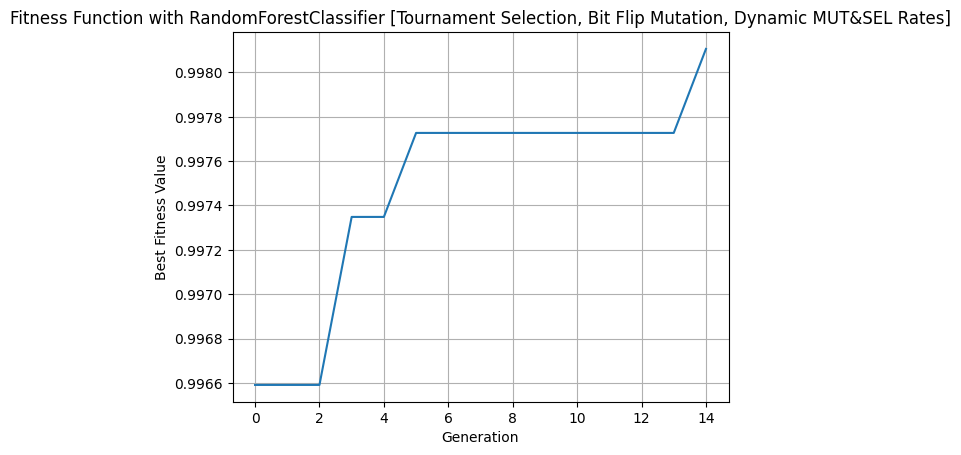

In [ ]:
fitness_type = 'randomforest'
num_desired_features = 5
selection_type = 'tournament'
mutation_type = 'bitflip'
crossover_rate = 0.7
mutation_rate = 0.01
changes_of_rates = True

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with RandomForestClassifier [Tournament Selection, Bit Flip Mutation, Dynamic MUT&SEL Rates]")

In [ ]:
fitness_type = 'randomforest'
num_desired_features = 5
selection_type = 'rank'
mutation_type = 'bitflip'
crossover_rate = 0.7
mutation_rate = 0.01
changes_of_rates = True

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with RandomForestClassifier [Rank Selection, Bit Flip Mutation, Dynamic MUT&SEL Rates]")

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' ROA(B) before interest and depreciation after tax', ' Pre-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Operating Expense Rate', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Operating Profit Per Share (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Cash Reinvestment %', ' Quick Ratio', ' Interest Expense Ratio', ' Total debt/Total net worth', ' Debt ratio %', ' Net worth/Assets', ' Long-term fund suitability ratio (A)', ' Operating profit/Paid-in capital', ' Inventory and accounts receivable/Net value', ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover Frequency', ' Net Worth Turnover Rate (times)', ' Revenue per person', ' Operating profit per person', ' Allocation rate per person', ' Working Capital to Total Assets', ' Current Assets/Total Assets', ' Cash/Total Assets', ' Cash/Current Liability', ' Current Liability to Assets', ' Inventory/Work

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Selected Features :  [' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Net Value Per Share (B)', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' After-tax Net Profit Growth Rate', ' Continuous Net Profit Growth Rate', ' Net Value Growth Rate', ' Total Asset Return Growth Rate Ratio', ' Quick Ratio', ' Interest Expense Ratio', ' Long-term fund suitability ratio (A)', ' Contingent liabilities/Net worth', ' Operating profit/Paid-in capital', ' Net profit before tax/Paid-in capital', ' Inventory and accounts receivable/Net value', ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover Frequency', ' Revenue per 

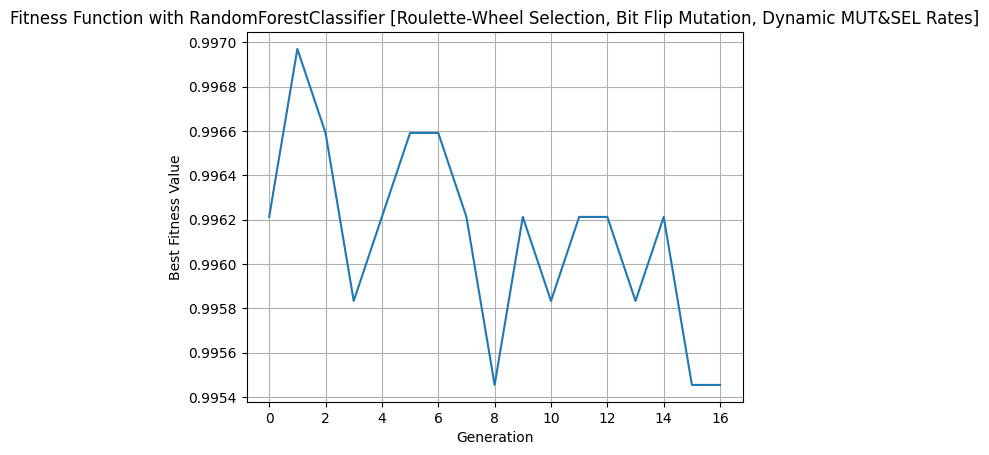

In [ ]:
fitness_type = 'randomforest'
num_desired_features = 5
selection_type = 'roulette'
mutation_type = 'bitflip'
crossover_rate = 0.7
mutation_rate = 0.01
changes_of_rates = True

fitnesses,best_features,best_fitness = feature_selection_genetic_algo(data,
                                                                      features,
                                                                      target,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      num_desired_features,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Fitness Function with RandomForestClassifier [Roulette-Wheel Selection, Bit Flip Mutation, Dynamic MUT&SEL Rates]")

# Fuzzy Logic Design

In [42]:
def define_fuzzy_input_variable(dataset):
    membership_functions = []

    for col in dataset.columns:
        min_val = np.min(dataset[col])
        max_val = np.max(dataset[col])
        mid_val = np.median(dataset[col])

        # Define the universe with reduced precision to save memory
        universe = np.arange(np.floor(min_val), np.ceil(max_val) + 0.1, 0.5)

        feature = ctrl.Antecedent(universe, str(col))
        feature['min'] = fuzz.trimf(feature.universe, [min_val, min_val, mid_val])
        feature['mid'] = fuzz.trimf(feature.universe, [min_val, mid_val, max_val])
        feature['max'] = fuzz.trimf(feature.universe, [mid_val, max_val, max_val])

        membership_functions.append(feature)


    return membership_functions

In [43]:
# def get_membership(dataset):
#   membership_dfs = []
#   for col in dataset.columns:
#     min_val = np.min(dataset[col])
#     max_val = np.max(dataset[col])
#     mid_val = np.median(dataset[col])

#     # Define the universe with reduced precision to save memory
#     universe = np.arange(np.floor(min_val), np.ceil(max_val) + 0.1, 0.5)

#     feature = ctrl.Antecedent(universe, str(col))
#     trimf_min = fuzz.trimf(feature.universe, [min_val, min_val, mid_val])
#     trimf_mid = fuzz.trimf(feature.universe, [min_val, mid_val, max_val])
#     trimf_max = fuzz.trimf(feature.universe, [mid_val, max_val, max_val])

#     membership_df = pd.DataFrame(dataset[col])
#     membership_df['min'] = fuzz.interp_membership(universe,trimf_min,dataset[col])
#     membership_df['mid'] = fuzz.interp_membership(universe,trimf_mid,dataset[col])
#     membership_df['max'] = fuzz.interp_membership(universe,trimf_max,dataset[col])
#     membership_df['membership'] = membership_df[['min','mid','max']].idxmax(axis = 1)
#     membership_df['degree'] = membership_df[['min','mid','max']].max(axis = 1)
#     membership_dfs.append(membership_df)
#   return membership_dfs

In [44]:
# membership_table = []
# membership_table.append(get_membership(X_train))

In [45]:
# Testing
best_features = [' Continuous interest rate (after tax)', ' Retained Earnings to Total Assets', ' Per Share Net profit before tax (Yuan ¥)', ' Interest Expense Ratio', ' ROA(C) before interest and depreciation before interest']
best_features = best_features[:5]
membership_functions = define_fuzzy_input_variable(X_train[best_features])

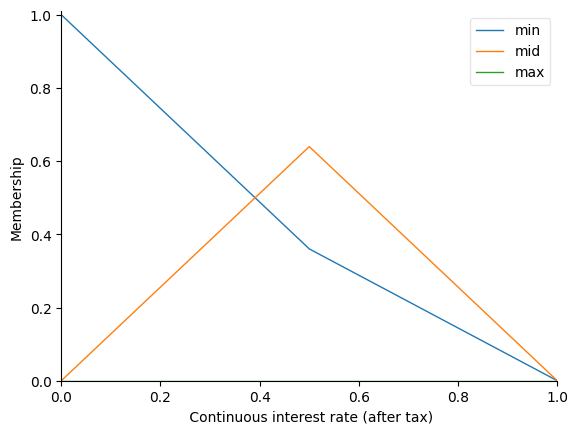

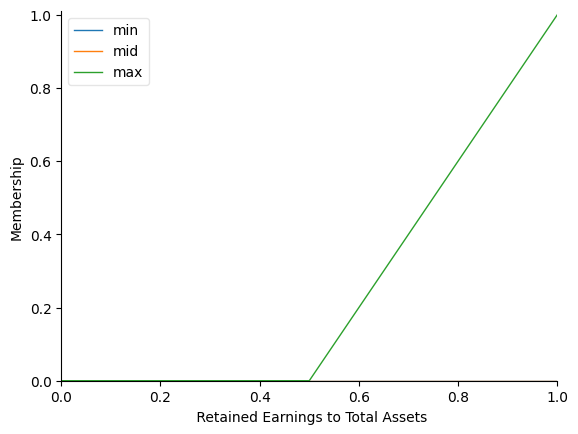

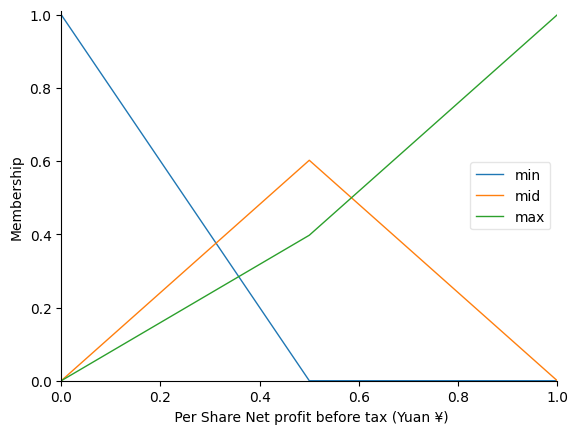

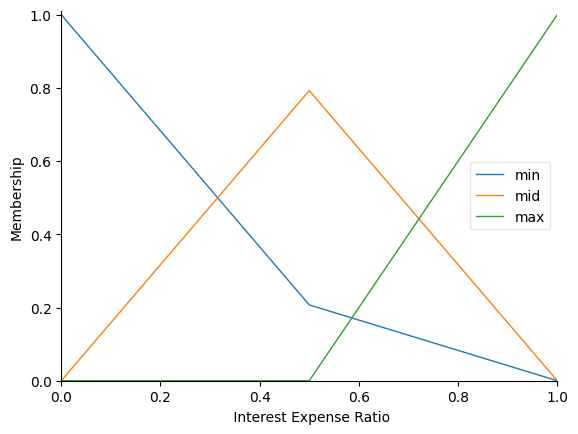

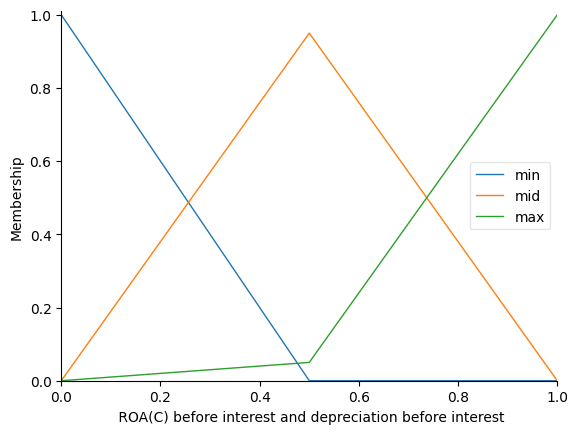

In [46]:
for i in range(len(membership_functions)):
  membership_functions[i].view()

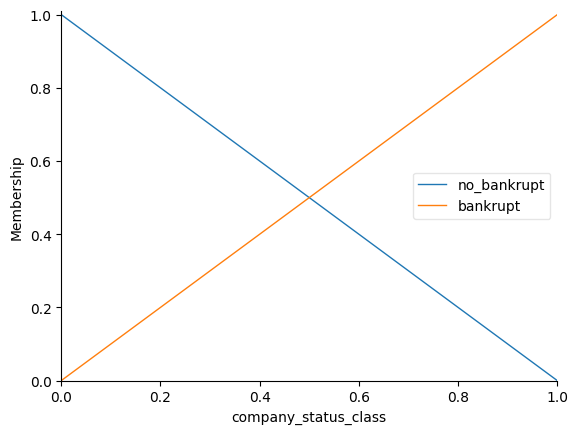

In [47]:
# Define output variable
company_status_class = ctrl.Consequent(np.arange(0,1.1,0.1),'company_status_class')


# Define membership functions for output variable
company_status_class['no_bankrupt'] = fuzz.trimf(company_status_class.universe, [0, 0, 1])
company_status_class['bankrupt'] = fuzz.trimf(company_status_class.universe, [0, 1, 1])

# View the membership functions
company_status_class.view()

In [48]:
# Generated rules - permutation / degrees
# genetic algorithms to get the best rules
# evaluate the model

In [49]:
# List of all antecedent combinations
antecedent_combinations = list(product(['min', 'mid', 'max'], repeat=len(membership_functions)))

# List of possible consequents
consequent_terms = ['no_bankrupt', 'bankrupt']

# Create fuzzy rules using combinations
rules = []
for antecedent in antecedent_combinations:
    antecedent_terms = list(antecedent)

    tempt_rules = []
    for ante_term,mf in zip(antecedent_terms,membership_functions):
      tempt_ante_membership = mf[ante_term]
      tempt_rules.append(tempt_ante_membership)

    for item in consequent_terms:
      rule = ctrl.Rule(reduce(lambda x, y: x & y, tempt_rules),company_status_class[item])
      rules.append(rule)

# Print the rules
for rule in rules:
    print(rule)


IF ((( Continuous interest rate (after tax)[min] AND  Retained Earnings to Total Assets[min]) AND  Per Share Net profit before tax (Yuan ¥)[min]) AND  Interest Expense Ratio[min]) AND  ROA(C) before interest and depreciation before interest[min] THEN company_status_class[no_bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax
IF ((( Continuous interest rate (after tax)[min] AND  Retained Earnings to Total Assets[min]) AND  Per Share Net profit before tax (Yuan ¥)[min]) AND  Interest Expense Ratio[min]) AND  ROA(C) before interest and depreciation before interest[min] THEN company_status_class[bankrupt]
	AND aggregation function : fmin
	OR aggregation function  : fmax
IF ((( Continuous interest rate (after tax)[min] AND  Retained Earnings to Total Assets[min]) AND  Per Share Net profit before tax (Yuan ¥)[min]) AND  Interest Expense Ratio[min]) AND  ROA(C) before interest and depreciation before interest[mid] THEN company_status_class[no_bankrupt]
	AND aggregation

# Rules Selection - GA Algorithms <br>
Types of fitness function
*   Accuracy
*   F1Score <br>

Selection methods

*   Tournament Selection
*   Rank Selection
*   Roulette-wheel Selection

Mutation methods

*   Bit Flip Mutation
*   Gaussian Mutation

Stopping Criteria

*   When fitness value > 0.90
*   When best fitness value does not improve for 15 consecutive generations

Changes of mutation and crossover rate every generation loop [TRUE / FALSE]

*   crossover_rate *= 1.05
*   mutation_rate *= 0.99

In [30]:
def accuracy_fitness_function_for_prediction(individual, rules_list, list_of_features):
    selected_rules = [rul for rul, bit in zip(rules_list, individual) if bit == 1]
    consequent_ctrl = ctrl.ControlSystem(selected_rules)
    pred = ctrl.ControlSystemSimulation(consequent_ctrl)

    predictions = []
    for i in range(len(X_test)):
        try:
            for feature_name, feature_value in zip(list_of_features, X_test.iloc[i]):
                pred.input[feature_name] = feature_value
            pred.compute()
            predict = 0 if pred.output['company_status_class'] < 0.5 else 1
            predictions.append(predict)
        except Exception as e:
            continue

    correct_predictions = sum(1 for pred, true_label in zip(predictions, y_test) if pred == true_label)
    acc = correct_predictions / len(y_test)

    return acc,

In [31]:
def f1score_fitness_function_for_prediction(individual,rules_list,list_of_features):
  selected_rules = [rul for rul,bit in zip(rules,individual) if bit == 1]
  consequent_ctrl = ctrl.ControlSystem(selected_rules)
  pred = ctrl.ControlSystemSimulation(consequent_ctrl)

  predictions = []
  for i in range(len(X_test)):
      try:
          for feature_name, feature_value in zip(list_of_features, X_test.iloc[i]):
              pred.input[feature_name] = feature_value
      except Exception as e:
          continue

      pred.compute()
      predict = 0 if pred.output['company_status_class'] < 0.5 else 1
      predictions.append(predict)

  TP = 0
  FP = 0
  TN = 0
  FN = 0

  for pred,true_label in zip(predictions,y_test):
    if pred == 1 and true_label == 1:
      TP +=1
    if pred == 0 and true_label == 0:
      TN += 1
    if pred == 1 and true_label == 0:
      FP += 1
    if pred == 0 and true_label == 1:
      FN += 1

  if TP + FP == 0 or TP + FN == 0:
    return 0.0,

  precision = TP / (TP + FP)
  recall = TP / (TP + FN)

  if precision + recall == 0:
    return 0.0,

  f1score = (2 * precision * recall) / (precision + recall)
  return f1score,

In [64]:
# Define a random state seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

def rules_selection_genetic_algo(data,target,rules,best_features,population_size,num_generations,fitness_type,selection_type = 'tournament',mutation_type = 'bitflip',crossover_rate = 0.7,mutation_rate = 0.01,changes_of_rates = True):
  best_fitness_in_generation = 0
  best_ind_in_generation = None
  best_rules_in_generation = None
  collection_of_fitnesses = []

  # Create the Fitness and Individual classes
  creator.create("FitnessMax",base.Fitness,weights = (1.0,))
  creator.create("Individual",list,fitness = creator.FitnessMax)

  # Initialize the toolbox
  toolbox = base.Toolbox()

  # Attribute generator: Define a function to randomly generate a feature selector (0 or 1)
  toolbox.register('attr_bool',random.randint,0,1)

  # Structure initializers: Define a function to create individuals and the population
  # toolbox.register('individual',init_individual,creator.Individual,size = len(features),num_features = 10)
  toolbox.register('individual',tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(rules))
  toolbox.register('population',tools.initRepeat,list,toolbox.individual)

  # Register the evaluation function
  if fitness_type == "accuracy":
    toolbox.register("evaluate",accuracy_fitness_function_for_prediction,rules_list = rules,list_of_features = best_features)
  elif fitness_type == "f1score":
    toolbox.register("evaluate",f1score_fitness_function_for_prediction,rules_list = rules,list_of_features = best_features)


  toolbox.register('mate',tools.cxTwoPoint)

  # Mutation
  if mutation_type == 'bitflip':
    toolbox.register('mutate',tools.mutFlipBit,indpb = 0.05)
  elif mutation_type == 'gaussian':
    toolbox.register('mutate',tools.mutGaussian,mu = 0,sigma = 1,indpb = 0.5)

  # Selection
  if selection_type == 'tournament':
    toolbox.register('select',tools.selTournament,tournsize  = 3)
  elif selection_type == 'roulette':
    toolbox.register('select',tools.selRoulette)
  elif selection_type == 'rank':
    toolbox.register('select',tools.selBest)

  # Initialize population
  population = toolbox.population(n = population_size)

  fitnesses = list(map(toolbox.evaluate,population))

  for ind,fit in zip(population,fitnesses):
    ind.fitness.values = fit

  # Variable keeping track of the number of generations
  gen = 0

  while gen < num_generations:
    gen+=1

    # Select the next generation individuals
    offspring = toolbox.select(population,len(population))

    # Clone the selected individuals
    offspring = list(map(toolbox.clone,offspring))

    # Apply crossover and mutation on the offspring
    for child1,child2 in zip(offspring[::2],offspring[1::2]):
      if random.random() < 0.5:
        toolbox.mate(child1,child2)
        del child1.fitness.values
        del child2.fitness.values

    for mutant in offspring:
      if random.random() < 0.2:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]

    fitnesses = map(toolbox.evaluate,invalid_ind)

    for ind,fit in zip(invalid_ind,fitnesses):
      ind.fitness.values = fit

    # Replace the population with the offspring
    population[:] = offspring

    # Stopping criteria
    best_ind_in_population = tools.selBest(population,1)[0]
    best_fitness_in_population = best_ind_in_population.fitness.values[0]

    selected_rules = [rul for rul,bit in zip(rules,best_ind_in_population) if bit == 1]

    print("Generation        : ",gen)
    print("Best Fitness      : ",best_fitness_in_population)
    print()

    if best_fitness_in_population > best_fitness_in_generation:
      best_fitness_in_generation = best_fitness_in_population
      best_ind_in_generation = best_ind_in_population
      best_rules_in_generation = selected_rules
      count_num_gen = 0
    else:
      count_num_gen += 1

    if changes_of_rates:
      #  Modify crossover rate and mutation -rate every generation loop
      crossover_rate *= 1.05
      mutation_rate *= 0.99

    collection_of_fitnesses.append(best_fitness_in_population)

    if best_fitness_in_population >= 0.9:
      break

    if count_num_gen == 15:
      break

  return collection_of_fitnesses,best_rules_in_generation,best_fitness_in_generation

In [40]:
# Plot the convergence
def plot_fitness_history(fitnesses,title):
  plt.plot(fitnesses)
  plt.xlabel("Generation")
  plt.ylabel("Best Fitness Value")
  plt.title(title)
  plt.grid()
  plt.show()

In [ ]:
population_size = 10
num_generations = 10
fitness_type = 'accuracy'
selection_type = 'tournament'
mutation_type = 'bitflip'
crossover_rate = 0.7
mutation_rate = 0.1
changes_of_rates = True

fitnesses, best_features, best_fitness = rules_selection_genetic_algo(X_train,
                                                                      y_train,
                                                                      rules,
                                                                      best_features,
                                                                      population_size,
                                                                      num_generations,
                                                                      fitness_type,
                                                                      selection_type,
                                                                      mutation_type,
                                                                      crossover_rate,
                                                                      mutation_rate,
                                                                      changes_of_rates)

print("\nBest Features : ", best_features)
print("Best Fitnes   : ", best_fitness)
plot_fitness_history(fitnesses,"Accuracy Fitness Function [Tournament Selection, Bit Flip Mutation, Dynamic MUT&SEL Rates]")

In [38]:
population_size = 5
num_generations = 10

best_rules,best_fitness = rules_selection_genetic_algo(X_train,y_train,rules,best_features,population_size,num_generations)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation        :  1
Best Fitness      :  0.31325757575757573

Generation        :  2
Best Fitness      :  0.31325757575757573

Generation        :  3
Best Fitness      :  0.31325757575757573

Generation        :  4
Best Fitness      :  0.31325757575757573

Generation        :  5
Best Fitness      :  0.31325757575757573

Generation        :  6
Best Fitness      :  0.31325757575757573

Generation        :  7
Best Fitness      :  0.31325757575757573

Generation        :  8
Best Fitness      :  0.31325757575757573

Generation        :  9
Best Fitness      :  0.31325757575757573

Generation        :  10
Best Fitness      :  0.31325757575757573

